# Project 3 - CAM을 만들고 평가해 보자

### 목표
- **ResNet50 + GAP + DenseLayer 결합된 CAM 모델 구현**
- **CAM 방식과 Grad-CAM 방식의 class activation map 시각화**
- **CAM과 Grad-CAM의 object localization 성능 비교분석**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import os
import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### (1) 데이터 준비

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='../tensorflow_datasets'
)

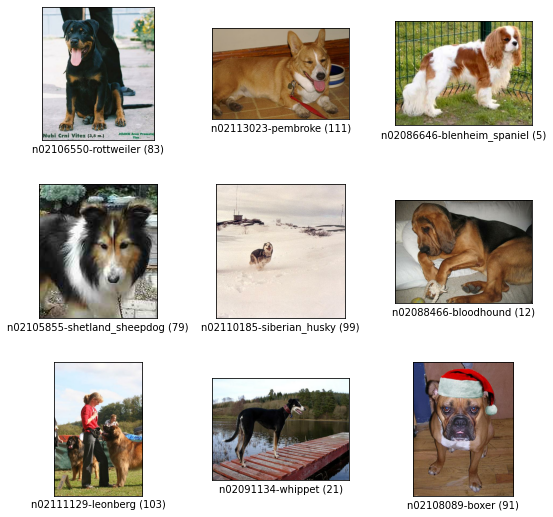

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

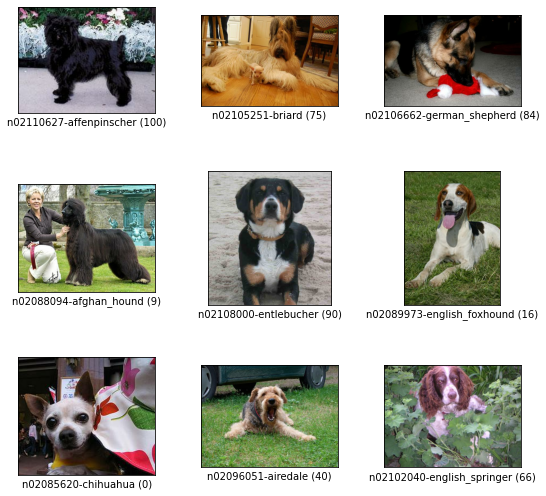

In [5]:
_ = tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

### (2) 데이터 전처리

In [7]:
def normalize_and_resize_img(data):
    image = tf.image.resize(data['image'], (224, 224))
    data['image'] = tf.cast(image, tf.float32) / 255.
    return data['image'], data['label']

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [9]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test, True)

for i in ds_train_norm.take(1):
    print(i[0].shape)
    print(i[1].shape)

(16, 224, 224, 3)
(16,)


### (3) ResNet-50 사전 학습 모델 불러오기

In [10]:
num_classes = ds_info.features['label'].num_classes

In [11]:
# ResNet-50 불러오기
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,   # 마지막 fully connected layer 제외
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'        # Global Average Pooling
)

# Dense Layer
x = base_model.output
output = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

cam_model = keras.Model(inputs=base_model.input, outputs=output, name="cam_model")

94781440/94765736 [==============================] - 0s 0us/step


In [12]:
cam_model.summary()

Model: "cam_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

### (4) 모델 학습

In [13]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

In [14]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 168s 210ms/step - loss: 2.2288 - accuracy: 0.4374 - val_loss: 3.3030 - val_accuracy: 0.2137
Epoch 2/15
750/750 [==============================] - 157s 209ms/step - loss: 0.7381 - accuracy: 0.7959 - val_loss: 1.0669 - val_accuracy: 0.6867
Epoch 3/15
750/750 [==============================] - 157s 209ms/step - loss: 0.2399 - accuracy: 0.9498 - val_loss: 0.9486 - val_accuracy: 0.7214
Epoch 4/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0287 - accuracy: 0.9990 - val_loss: 0.9217 - val_accuracy: 0.7394
Epoch 6/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0186 - accuracy: 0.9991 - val_loss: 0.9646 - val_accuracy: 0.7364
Epoch 7/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0133 - accuracy: 0.9996 - val_loss: 0.9666 - val_accuracy: 0.7390
Epoch 8/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0097 - accuracy: 0.9998 - val_loss: 0.9583 -

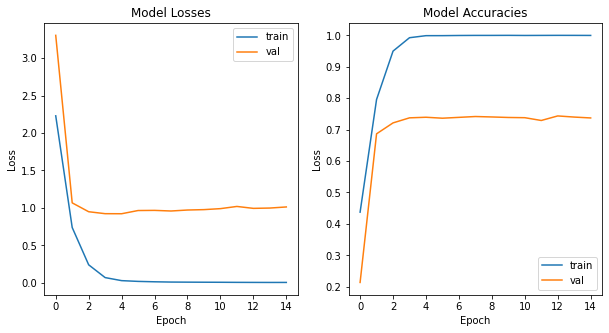

In [18]:
plt.figure(figsize=(10, 5))

# train, validation loss graph
plt.subplot(1, 2, 1)
plt.plot(history_cam_model.history['loss'])
plt.plot(history_cam_model.history['val_loss'])
plt.title('Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

# validation accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history_cam_model.history['accuracy'])
plt.plot(history_cam_model.history['val_accuracy'])
plt.title('Model Accuracies')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')

In [19]:
import os
cam_model_path = './cam_model.h5'
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


---

In [20]:
new_cam_model = tf.keras.models.load_model(cam_model_path)

### (5) 예제 데이터 추출

In [93]:
SAMPLE_NUM = 5

In [94]:
sample_ds = list(ds_test.take(SAMPLE_NUM).as_numpy_iterator())

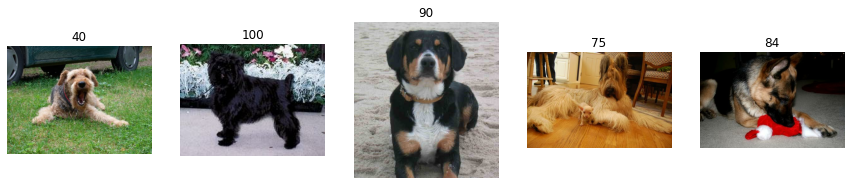

In [95]:
plt.figure(figsize=(15,3))

for i, d in enumerate(sample_ds):
    plt.subplot(1, len(sample_ds), i+1)
    plt.axis('off')
    plt.title(d['label'])
    plt.imshow(d['image'])

In [96]:
def plot_images(ds, image_list):
    plt.figure(figsize=(15,3))

    for i, d in enumerate(ds):
        plt.subplot(1, len(ds), i+1)
        plt.axis('off')
        plt.title(d['label'])
        plt.imshow(image_list[i])

### (6) CAM 구현

In [97]:
def generate_cam(model, data):
    item = copy.deepcopy(data)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # output = feature map, output
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # weight activation
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # resize
    
    return cam_image

In [98]:
cam_image_list = []

for i, d in enumerate(sample_ds):
    cam_image = generate_cam(cam_model, d)
    cam_image_list.append(cam_image)

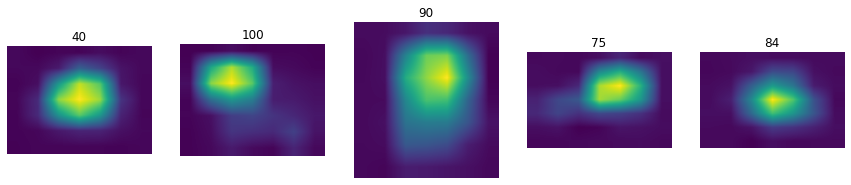

In [99]:
plot_images(sample_ds, cam_image_list)

In [100]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    beta = (1.0 - alpha)
    image = image.astype(np.uint8)
    cam_image = np.stack([cam_image * 255] * 3, axis=-1).astype(np.uint8)
    
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    
    return merged_image

In [101]:
cam_merged_image_list = []

for i, d in enumerate(sample_ds):
    cam_merged_image = visualize_cam_on_image(d['image'], cam_image_list[i])
    cam_merged_image_list.append(cam_merged_image)

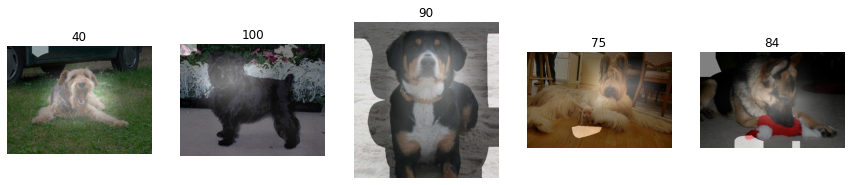

In [102]:
plot_images(sample_ds, cam_merged_image_list)

### (7) Grad-CAM 구현

In [103]:
def generate_grad_cam(model, activation_layer, data):
    item = copy.deepcopy(data)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # output = feature map, output
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image) # ReLU
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

In [104]:
grad_5_cam_image_list = []

for i, d in enumerate(sample_ds):
    grad_5_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', d)
    grad_5_cam_image_list.append(grad_5_cam_image)

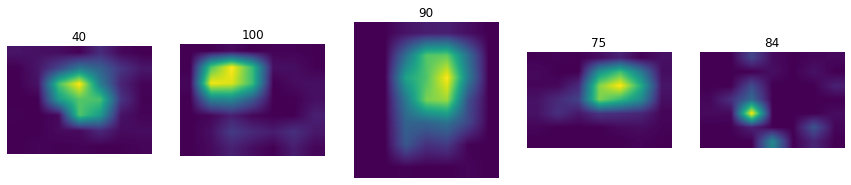

In [105]:
plot_images(sample_ds, grad_5_cam_image_list)

In [106]:
grad_4_cam_image_list = []

for i, d in enumerate(sample_ds):
    grad_4_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', d)
    grad_4_cam_image_list.append(grad_4_cam_image)

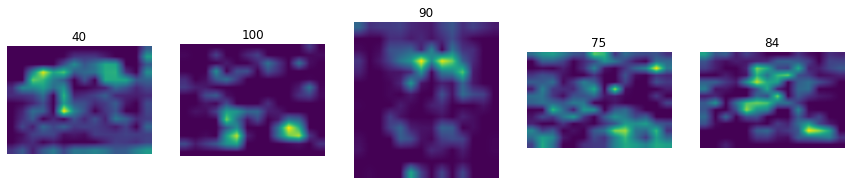

In [107]:
plot_images(sample_ds, grad_4_cam_image_list)

In [108]:
grad_3_cam_image_list = []

for i, d in enumerate(sample_ds):
    grad_3_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', d)
    grad_3_cam_image_list.append(grad_3_cam_image)

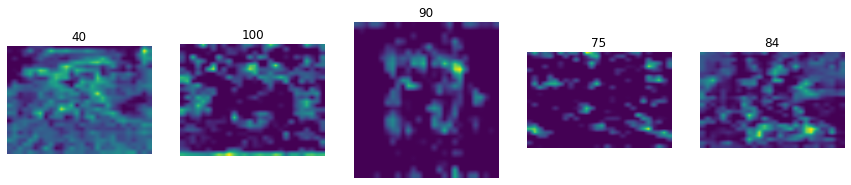

In [109]:
plot_images(sample_ds, grad_3_cam_image_list)

### (8) 전체 Activation Map 비교

In [110]:
image_list_dict = {
    'origin' : sample_ds,
    'cam' : cam_image_list,
    'grad cam 5' : grad_5_cam_image_list,
    'grad cam 4' : grad_4_cam_image_list,
    'grad cam 3' : grad_3_cam_image_list
}

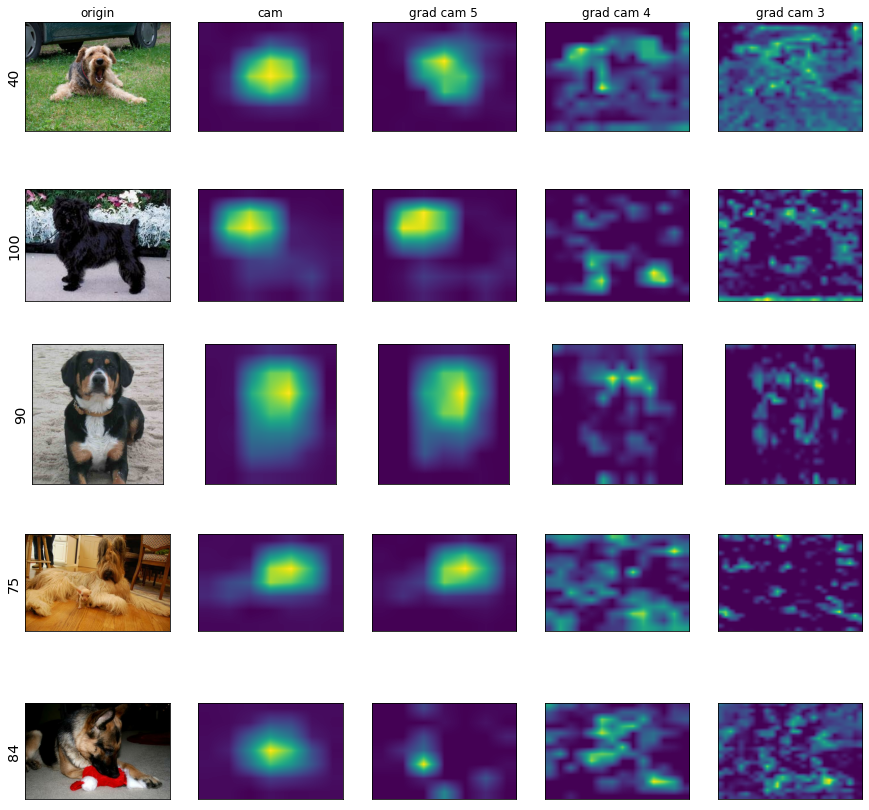

In [132]:
plt.figure(figsize=(15,15))

for i, list_name in enumerate(image_list_dict):
    for j, d in enumerate(image_list_dict[list_name]):
        plt.subplot(len(sample_ds), len(sample_ds), i+j*len(sample_ds)+1)
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        
        if i == 0:
            plt.ylabel(d['label'], fontdict={'size' : 'x-large'})
        if j == 0:
            plt.title(list_name)
        
        if i == 0:
            plt.imshow(d['image'])
        else:
            plt.imshow(d)

### (9) 바운딩 박스 구하기

In [151]:
def get_bbox(cam_image, score_thresh=0.01):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    
    return rect

In [152]:
cam_bbox_list = []

for i, img in enumerate(cam_image_list):
    rect = get_bbox(img)
    bbox_image = copy.deepcopy(sample_ds[i]['image'])
    bbox_image = cv2.drawContours(bbox_image, [rect], 0, (0,0,255), 2)
    cam_bbox_list.append(bbox_image)

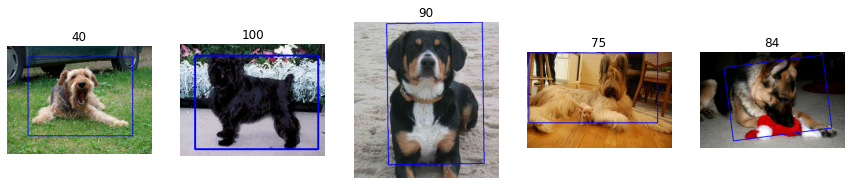

In [153]:
plot_images(sample_ds, cam_bbox_list)

In [154]:
grad_cam_bbox_list = []

for i, img in enumerate(grad_5_cam_image_list):
    rect = get_bbox(img)
    bbox_image = copy.deepcopy(sample_ds[i]['image'])
    bbox_image = cv2.drawContours(bbox_image, [rect], 0, (0,0,255), 2)
    grad_cam_bbox_list.append(bbox_image)

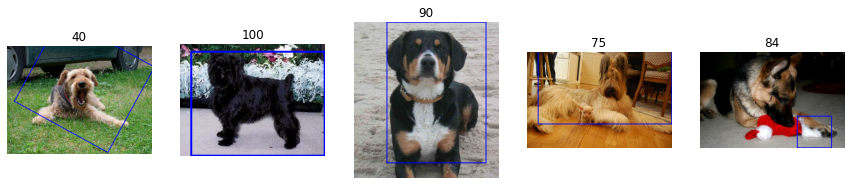

In [155]:
plot_images(sample_ds, grad_cam_bbox_list)

### (10) IoU 구하기

In [156]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [157]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [163]:
print("CAM IoU of classes")
for i, img in enumerate(cam_image_list):
    rect = get_bbox(img)
    pred_bbox = rect_to_minmax(rect, img)
    print(f"{sample_ds[i]['label']}: {get_iou(pred_bbox, sample_ds[i]['objects']['bbox'][0])}")

CAM IoU of classes
40: 0.7293699994172859
100: 0.7663687157643371
90: 0.8189625859160842
75: 0.7501603478235574
84: 0.7313136380598755


In [164]:
print("Grad-CAM IoU of classes")
for i, img in enumerate(grad_5_cam_image_list):
    rect = get_bbox(img)
    pred_bbox = rect_to_minmax(rect, img)
    print(f"{sample_ds[i]['label']}: {get_iou(pred_bbox, sample_ds[i]['objects']['bbox'][0])}")

Grad-CAM IoU of classes
40: 0.3149955476079782
100: 0.6932517362226835
90: 0.7917517149379072
75: 0.7764359209823435
84: 0.0609235607849645


- 전체적으로 grad-CAM 보다 CAM의 IoU가 더 높게 나타났다.